In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Initialization

In [2]:
!pip install scikit-image==0.18.1

     |████████████████████████████████| 29.2 MB 1.5 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import cv2
import csv
import os
import math 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import random 
from ipywidgets import interact
from sklearn.preprocessing import Normalizer
import pickle
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import time
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import skimage
from skimage.transform import resize
import tensorflow as tf
from PIL import Image
from IPython.display import clear_output


In [106]:
df = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/dataframe.json') # load image df
result=pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/result.json') # load saved result 
localization_df=pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/localization df.json') # load localization result df 

In [ ]:
print(list(result.columns))
print(list(df.columns))
print(list(localization_df.columns))

['detection_rate', 'percent_detection', 'Fscore_OD', 'Fscore_OC', 'OD center', 'disk_center', 'Fscore_OD_unfit', 'Fscore_OC_unfit', 'disc_centers_mvo']
['path', 'file_name', 'path_OD', 'path_OC', 'disc_center', 'tag', 'dataset', 'shape', 'path_OD_png', 'path_OC_png']
['histogram', 'image_g', 'image_gb', 'image_gr', 'image_rgb', 'image_gr_1', 'image_gr_1_0514', 'image_gr_1_5101', 'image_gr_1_5104']


In [5]:
# Load Optic Disc Image Templates
image_R = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Template/ROItemplateRed.png', 0)
image_G = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Template/ROItemplateGreen.png', 0)
image_B = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Template/ROItemplateBlue.png', 0)
image_templates = [image_R, image_G, image_B]


# This templates is for histogram template matching method (Privous method from Mvoulana, et al)
template_hist = pd.read_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Template/templatehist.json')
hist_templates = [template_hist['red'], template_hist['green'], template_hist['blue']]

# Localization Main Function

In [17]:
def extract_BR_map(src, mask, numSegments=50, sigma=10):
  """
    This is the function of brightness map of retinal images extraction. 
    Brightness map is an image that contain well-segmented areas of retinal images
    that filled with the brightness of those areas. This maps give the brightness
    information of all area in retinal image. Since the Optic Disc typically
    the one of brightest area in retinal images, this map helps identify the
    location of Optic Disc.
    
    Input:
    src: retinal images (RGB)
    mask: mask for Masking out non-retinal area of the image
    numSegments: The number of segment in the brightness map
    sigma: the size of gaussian filter for blurring the image

    Output:
    Brightnes map: the combined brightness across R, G, B channels
  """

  #Resize imagen source
  H, W = src.shape[:2]
  
  # Resizing the image to quarter size for accelerating the computation
  resized_src = resize(src, output_shape=(H//4, W//4), mode = 'constant')
  resized_mask =  resize(mask, output_shape=(H//4, W//4), mode = 'constant')

  # Blurring the image tim improve the segment accuracy
  blur = cv2.GaussianBlur(resized_src, (37, 37), 0)

  # Segmenting the retinal image using SLIC algorithm 
  segments = slic(blur, n_segments=numSegments, sigma=sigma, mask=resized_mask)
  # boundary = mark_boundaries(resized_src, segments)

  labels = np.unique(segments)
  h, w = resized_src.shape[:2]

  # initiate the brightness map of R, G, and B channel
  g_map = np.zeros([h, w], np.float32)
  r_map = np.zeros([h, w], np.float32)
  b_map = np.zeros([h, w], np.float32)


  r_src = resized_src[:, :, 0]
  g_src = resized_src[:, :, 1]
  b_src = resized_src[:, :, 2]

  # Filling the segment with brightness of it
  for label in labels:
    # Brightness is define as the maximum intensity of each segment
    r_map[segments==label] = np.max(r_src[segments==label])
    g_map[segments==label] = np.max(g_src[segments==label])
    b_map[segments==label] = np.max(b_src[segments==label])

  # Resize back the brightness map to its original size
  r_resized_map = resize(r_map, output_shape=(H, W), mode='constant', preserve_range=True)
  g_resized_map = resize(g_map, output_shape=(H, W), mode='constant', preserve_range=True)
  b_resized_map = resize(b_map, output_shape=(H, W), mode='constant', preserve_range=True)

  # combining brightness map using average method
  combined_brightness_map = (r_resized_map + g_resized_map + b_resized_map)/3
  
  return combined_brightness_map

def padding(NCC, h, w):
  """
    This function will zero padding the NCC map such that NCC map have the same size
    with retinal images
  """

  ver = (h - NCC.shape[0])/2
  hor = (w - NCC.shape[1])/2
  top = math.floor(ver)
  bottom = math.ceil(ver)
  left =  math.floor(hor)
  right = math.ceil(hor)
  value = 0
  borderType = cv2.BORDER_CONSTANT
  zeropadded_NCC = cv2.copyMakeBorder(NCC, top, bottom, left, right, borderType, value)
  return zeropadded_NCC

def image_template_matching(clahe_retinal_img, template, mask):
  """
    This is a function for OD template matching. This will yields Normalized
    Correlation Coefficient (NCC) of R, G, and B channel. 

    Input:
    clahe_retinal_img: RGB retinal image that had been CLAHE-ed
    template: OD template image 
    mask: Mask for masking out the non-retinal area

    Output: 
    NCC_maps: NCC image of R, G, and B channel
  """

  h, w = clahe_retinal_img[0].shape[:2]
  NCC_maps = []
  for i, clahe_image in enumerate(clahe_retinal_img):
    # checking clahe image isn't zeros 
    if len(np.unique(clahe_image)) > 0: 
      NCC = cv2.matchTemplate(clahe_image, template[i], cv2.TM_CCOEFF_NORMED)
      NCC = NCC + abs(np.min(NCC))
      NCC = padding(NCC, h, w)
      NCC = NCC * mask

    NCC_maps.append(NCC)
  
  return NCC_maps


In [18]:
def OD_Localization(src, template_images, used_channels='rgb',
                  bright_on=True, test_on=False, 
                  r_coeff=1, g_coeff=1, b_coeff=1, br_coeff=1):
  """
    This is the main function for localization of Optic Disc
    
    Input:
    src: retinal images (RGB)
    template_images: Optic Disc template images of R, G, B channles
    used_channels: defining the used NCC channels for localization
    NCC_on : Use NCC map for localization
    bright_on : Use brightness map for localization
    r_coeff: coefficient of red_NCC map 
    g_coeff: coefficient of green_NCC map 
    b_coeff: coefficient of blue_NCC map 
    br_coeff: coefficient of brightness map 

    Output:
    disk_center: Optic Disc Center
    all_maps: list of created maps for localization, returned only if 
    test_on is True.
  """

    
  h, w = src.shape[:2]

  # Implement CLAHE to the input image 
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(src[:, :, 1])
  
  zeros = np.zeros([h, w], np.uint8)
  img = [zeros, zeros, zeros]
  
  # Apply CLAHE to each of image channel 
  for channel in used_channels:
    if channel == 'r':
      img[0] = clahe.apply(src[:, :, 0])
    elif channel == 'g':
      img[1] = clahe.apply(src[:, :, 1])
    elif channel == 'b':
      image = clahe.apply(src[:, :, 2])
      img[2] = image
    
  # Mask Out outside retinal image
  blurred = cv2.GaussianBlur(cl_img, (7, 7), 0)
  (T, mask) = cv2.threshold(blurred, 10 , 255, cv2.THRESH_BINARY)
  mask = mask/255

  # Extract the NCC maps
  red_NCC, green_NCC, blue_NCC = image_template_matching(img, template_images, mask)

  # Extract superpixel map
  if bright_on:
    brightness_map = extract_BR_map(src, mask)
  else:
    brightness_map = zeros

  # Combining localization maps 
  combined_map = red_NCC * r_coeff + green_NCC*g_coeff + blue_NCC*b_coeff + brightness_map*br_coeff
  all_maps = [combined_map, red_NCC, green_NCC, blue_NCC, brightness_map]
  
  # Extracting maximum value of NCC
  y, x = list(zip(*np.where(combined_map==np.max(combined_map))))[0]
  disk_center = (x, y)

  # Return all maps for testing the algorithm only
  if test_on:
    return disk_center, all_maps 
  elif not test_on:
    return disk_center


# Secondary Function

In [8]:
def index_shuffle(f, random_state=4):
  ix_dr_gl = np.array(list(range(0, 32)))
  ix_dr_n = np.array(list(range(32, 50)))
  ix_re_gl = np.array(list(range(50, 90)))
  ix_re_n = np.array(list(range(90, 450)))
  
  random.Random(random_state).shuffle(ix_dr_gl)
  random.Random(random_state).shuffle(ix_dr_n)
  random.Random(random_state).shuffle(ix_re_gl)
  random.Random(random_state).shuffle(ix_re_n)
  # test_size = 1/k
  # [x*test_size for x in list(range(0, 33, test_size*32))]
  dr_gl = np.array([0, 6, 12, 18, 25, 32]) # portion of each fold for drishti-glaucoma data
  dr_n = np.array([0, 3, 6, 10, 14, 18]) # portion of each fold for drishti-normal data
  re_gl = np.array([0, 8, 16, 24, 32, 40]) # portion of each fold for refuge-glaucoma data
  re_n = np.array([0, 72, 144, 216, 288, 360]) # portion of each fold for refuge-normal data
  
  i = f - 1
  # meta-index for train data
  tr_dr_gl = list(range(dr_gl[i])) + list(range(dr_gl[i+1], 32))
  tr_dr_n = list(range(dr_n[i])) + list(range(dr_n[i+1], 18))
  tr_re_gl = list(range(re_gl[i])) + list(range(re_gl[i+1], 40))
  tr_re_n = list(range(re_n[i])) + list(range(re_n[i+1], 360))

  # meta-index for test data
  te_dr_gl = list(range(dr_gl[i], dr_gl[i+1])) 
  te_dr_n = list(range(dr_n[i], dr_n[i+1]))
  te_re_gl = list(range(re_gl[i], re_gl[i+1]))
  te_re_n = list(range(re_n[i], re_n[i+1]))

  ix_train = np.concatenate((ix_dr_gl[tr_dr_gl], ix_dr_n[tr_dr_n],
                               ix_re_gl[tr_re_gl], ix_re_n[tr_re_n]))
  ix_test = np.concatenate((ix_dr_gl[te_dr_gl], ix_dr_n[te_dr_n],
                              ix_re_gl[te_re_gl],  ix_re_n[te_re_n]))
  
  random.Random(random_state).shuffle(ix_train)
  random.Random(random_state).shuffle(ix_test)


  return ix_train, ix_test

In [9]:
def index_shuffle_temp(ix_train, num_sample, random_state=4):
    ix_dr_gl = np.array([idx for idx in ix_train if idx < 32])
    ix_dr_n = np.array([idx for idx in ix_train if idx >= 32 and idx < 50])
    ix_re_gl = np.array([idx for idx in ix_train if idx >= 50 and idx < 90])
    ix_re_n = np.array([idx for idx in ix_train if idx >= 90 and idx < 450])

    random.Random(random_state).shuffle(ix_dr_gl)
    random.Random(random_state).shuffle(ix_dr_n)
    random.Random(random_state).shuffle(ix_re_gl)
    random.Random(random_state).shuffle(ix_re_n)
    portion = num_sample/len(ix_train)
    ix_dr_gl = ix_dr_gl[:int(len(ix_dr_gl)*portion)]
    ix_dr_n = ix_dr_n[:int(len(ix_dr_n)*portion)]
    ix_re_gl = ix_re_gl[:int(len(ix_re_gl)*portion)]
    ix_re_n = ix_re_n[:int(len(ix_re_n)*portion)]
    idx = np.concatenate((ix_dr_gl, ix_dr_n, ix_re_gl, ix_re_n))
    random.Random(random_state).shuffle(idx)
    non_idx = list(set(idx).symmetric_difference(set(list(range(0, 450)))))
    return idx, non_idx

In [10]:
# Fungsi untuk mengekstrak TP, TN, FP, FN dari input yang berbeda
# input : ground truth dan prediksi. kedua objek tersebut harus sama sizenya (uint8)
# output : TP, TN, FP, FN

def checkROI(OD, center):
  mvoulana = 0
  zheng = 0
  luasgtAsli = np.sum(OD==255)
  ROI, _ = ekstrakROI(center, 550, OD)
  luasgtROI = np.sum(ROI==255)
  presentasi = (luasgtROI/ luasgtAsli) * 100
  coordinates = np.where(OD==255)
  coordinates = list(zip(*coordinates))
  center_temp = (center[1], center[0])

  # kriteria mvoulana
  if center_temp in coordinates:
    mvoulana = 1
  if presentasi == 100:
    zheng = 1
  return presentasi, mvoulana, zheng

In [11]:
#make image template
def build_template(df, ix_train, num_sample=100, random_state=4, 
                         old_ver=False, save=False, tipe='int', index=True):
 
    ix_dr_gl = np.array([idx for idx in ix_train if idx < 32])
    ix_dr_n = np.array([idx for idx in ix_train if idx >= 32 and idx < 50])
    ix_re_gl = np.array([idx for idx in ix_train if idx >= 50 and idx < 90])
    ix_re_n = np.array([idx for idx in ix_train if idx >= 90 and idx < 450])

    random.Random(random_state).shuffle(ix_dr_gl)
    random.Random(random_state).shuffle(ix_dr_n)
    random.Random(random_state).shuffle(ix_re_gl)
    random.Random(random_state).shuffle(ix_re_n)
    portion = num_sample/len(ix_train)
    ix_dr_gl = ix_dr_gl[:int(len(ix_dr_gl)*portion)]
    ix_dr_n = ix_dr_n[:int(len(ix_dr_n)*portion)]
    ix_re_gl = ix_re_gl[:int(len(ix_re_gl)*portion)]
    ix_re_n = ix_re_n[:int(len(ix_re_n)*portion)]
    idx = np.concatenate((ix_dr_gl, ix_dr_n, ix_re_gl, ix_re_n))
    random.Random(random_state).shuffle(idx)
      
    template_image_R = np.zeros([551, 551], np.float32)
    template_image_G = np.zeros([551, 551], np.float32)
    template_image_B = np.zeros([551, 551], np.float32)
    template_hist_R = np.zeros(256, np.float32)
    template_hist_G = np.zeros(256, np.float32)
    template_hist_B = np.zeros(256, np.float32)

    for i in idx:
        src = cv2.imread(df['path'][i], 1)
        src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        src_r = src[:, :, 0]
        src_g = src[:, :, 1]
        src_b = src[:, :, 2]

        clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
        src_rc = clahe.apply(src_r)
        src_gc = clahe.apply(src_g)
        src_bc = clahe.apply(src_b)
        temp_r, _ = ekstrakROI(df['disc_center'][i], 551, src_r)
        temp_g, _ = ekstrakROI(df['disc_center'][i], 551, src_g)
        temp_b, _ = ekstrakROI(df['disc_center'][i], 551, src_b)
        temp_rc, _ = ekstrakROI(df['disc_center'][i], 551, src_rc)
        temp_gc, _ = ekstrakROI(df['disc_center'][i], 551, src_gc)
        temp_bc, _ = ekstrakROI(df['disc_center'][i], 551, src_bc)
        red_hist = np.array(cv2.calcHist([temp_r], [0], None, [256], [0,256])).squeeze()
        green_hist = np.array(cv2.calcHist([temp_g], [0], None, [256], [0,256])).squeeze()
        blue_hist = np.array(cv2.calcHist([temp_b], [0], None, [256], [0,256])).squeeze()

        template_hist_R += red_hist
        template_hist_G += green_hist
        template_hist_B += blue_hist
        template_image_R += temp_r
        template_image_G += temp_g
        template_image_B += temp_b

    template_hist_R = ((template_hist_R)/len(idx)) 
    template_hist_G = ((template_hist_G)/len(idx))
    template_hist_B = ((template_hist_B)/len(idx))
    template_image_R = ((template_image_R)/len(idx)) 
    template_image_G = ((template_image_G)/len(idx))
    template_image_B = ((template_image_B)/len(idx))

    if tipe=='int':
      #template_hist_R = template_hist_R.astype(np.uint8)
      #template_hist_G = template_hist_G.astype(np.uint8)
      #template_hist_B = template_hist_B.astype(np.uint8)
      template_image_R = template_image_R.astype(np.uint8)
      template_image_G = template_image_G.astype(np.uint8)
      template_image_B = template_image_B.astype(np.uint8)
    if save:
      filepath = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/'
      cv2.imwrite(filepath+'ROItemplateRed.png', template_image_R) 
      cv2.imwrite(filepath+'ROItemplateGreen.png', template_image_G) 
      cv2.imwrite(filepath+'ROItemplateBlue.png', template_image_B) 
      template_hist = pd.DataFrame({'red':template_hist_R, 'green':template_hist_G, 
                                    'blue':template_hist_B})
      template_hist.to_json(filepath+'templatehist.json')
    image_templates = [template_image_R, template_image_G, template_image_B]
    hist_templates = [template_hist_R, template_hist_G, template_hist_B]
    if index:
     return image_templates, hist_templates, idx
    else:
     return image_templates, hist_templates


In [12]:
def maxima(d_img):
# Input : distance map 
# output : max point map (maxima) 
  height, width = d_img.shape

  maxima = np.zeros(d_img.shape, np.uint8)
  th = np.max(d_img)/2
  maxima[d_img > th] = 255

  return maxima

In [68]:
# Replication of OD Localization by Zhang, et al.
def zhang_localization(src):
  img = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
  T = 0.95 * np.max(img)
  _, t_img = cv2.threshold(img, T, 1, cv2.THRESH_BINARY)
  h, w = img.shape[:2]
  w_reg = w // 8
  h_reg = h // 8
  sum_pixel = []
  coor_pixel = []
  for y_init in range(0, h - h_reg, h_reg):
    for x_init in range(0, w - w_reg, w_reg):
      y1, y2, x1, x2 = y_init, y_init + h_reg, x_init, x_init + w_reg
      sum = np.sum(t_img[y1 : y2, x1 : x2])
      sum_pixel.append(sum)
      coor_pixel.append([y1, y2, x1, x2])
  
  sum_pixel = np.array(sum_pixel)
  y1, y2, x1, x2 = coor_pixel[np.argmax(sum_pixel)]
  disk_center = ((x1 + x2)//2 , (y1 + y2)//2)
  return disk_center  

In [113]:
# Replication of OD Localization by Mvoulana, et al.
def extractcentroids(maxima):
  # mencari centroid dari setiap blob maxima
  centroids = []
  contours, hierarchy  = cv2.findContours(maxima,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)
    # calculate x,y coordinate of center
    if M["m00"] != 0:
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      p = [cX, cY]
      centroids.append(p)
    
  return centroids

def bright_detection(src): 
  ### Preprocessing #######################################################
  # ekstraksi kanal hijau citra
  img = src[:,:,1]

  # CLAHE
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  cl_img = clahe.apply(img)

  ### Lokalisasi OD ######################################################

  ret,_ = cv2.threshold(cl_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  cons = 6/3
  T = 0.95 * np.max(img)
  # modified otsu thresholding
  th = ret*cons
  _, otsu_img = cv2.threshold(cl_img,T,255,cv2.THRESH_BINARY)

  # Distance Map 
  dist_img = cv2.distanceTransform(otsu_img, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

  # Maximum pixel at distance map
  maxima_img = maxima(dist_img)
  maxima_img = cv2.convertScaleAbs(maxima_img)
  
  # Ekstrak centroid berpotensi sebagai disc center
  centers = extractcentroids(maxima_img)
  return centers

def correlation_form(hist, hist_temp):
  diff = hist - hist_temp
  diff = diff**2
  diff = np.sum(diff)
  corr = 1/(1+diff)

  return corr
def histogram_template_matching(src, hist_temps):
  centroids = bright_detection(src)
  a, b, c = (0.5, 2, 1)
  Cs = []
  center = []

  for i in range(len(centroids)):

    centroid = centroids[i]
    
    #cropping ROI from source image
    ROI, _ = ekstrakROI(centroid, 550, src)

    # Green channel histogram, 0 : red, 1 : green, 2 : blue
    red_hist = np.array(cv2.calcHist([ROI], [0], None, [256], [0,256])).squeeze()
    green_hist = np.array(cv2.calcHist([ROI], [1], None, [256], [0,256])).squeeze()
    blue_hist = np.array(cv2.calcHist([ROI], [2], None, [256], [0,256])).squeeze()

    #calc correlation formula
    cr = correlation_form(red_hist, hist_temps[0])
    cg = correlation_form(green_hist, hist_temps[1])
    cb = correlation_form(blue_hist, hist_temps[2])

    C = a*cr + b*cg + c*cb
    Cs.append(C)
  
  max_ix = np.argmax(Cs)
  center = centroids[max_ix]
  return center

In [15]:
def ekstrakROI(centroid, s, img):

  h, w = img.shape[:2]
 
  y0, y1, x0, x1 = rectfromcenter(centroid, s, h, w)

  #cropping ROI from source image
  ROI = img[y0:y1, x0:x1]
  koordinat = (y0, y1, x0, x1)

  return ROI, koordinat

In [16]:
def rectfromcenter(center, s, h, w):
  x, y = center
  x0 = math.floor(x - 0.5*s)
  x1 = math.floor(x + 0.5*s)
  y0 = math.floor(y - 0.5*s)
  y1 = math.floor(y + 0.5*s)
  #dx = (x1 - x0) - s
  #dy = (y1 - y0) - s
  # penanganan kasus out of image
  if (x0 < 0):
    x1 = x1 + (-x0)
    x0 = 0
    #x1 -= dx
  elif (x1 > w-1):
    x0 = x0 - (x1-(w-1))
    x1 = w-1
    #x0 += dx
  #else:
  #  x0 += dx

  if (y0 < 0):
    y1 = y1 + (-y0)
    y0 = 0
    #y1 -= dy
  elif (y1 > h-1):
    y0 = y0 - (y1-(h-1))
    y1 = (h-1)
    #y0 += dy
  #else:
    #y0 += dy

  return y0, y1, x0, x1

#  Localization Showcase

In [ ]:
# Fungsi ini hanya digunakan untuk menampilkan hasil lokalisasi 
def try_localization(i=0):
    image_path = df["path"][i] # path image retina yang dituju
    # tunned parameter
    r_coeff, g_coeff,b_coeff, br_coeff = 1, 0.2, 0, 0.8
    used_channels = 'rg'
    src_image = cv2.imread(image_path, 1) # reading image retina
    src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB) # Konversi warna BGR ke RGB
    disk_center, all_maps = OD_Localization(src_image, image_templates, 
                                            used_channels=used_channels, 
                                            bright_on=True, 
                                            test_on=True, 
                                            r_coeff=r_coeff, 
                                            g_coeff=g_coeff, 
                                            b_coeff=b_coeff,
                                            br_coeff=br_coeff)
    
    combined_map = all_maps[0] 

    # Showing disk center location and combined map
    fig, ax = plt.subplots(1, 2, figsize=(7, 14))
    plt.setp(ax, xticks=[], yticks=[])
    ax[0].imshow(src_image)
    ax[0].scatter(disk_center[0], disk_center[1], s=20, color='blue', marker='x')
    ax[0].set_title('Center of Optic Disc')
    ax[1].imshow(combined_map, cmap='gray')
    ax[1].set_title('Combined Map')
    plt.show()

interact(try_localization, i=(0, len(df)-1))

interactive(children=(IntSlider(value=0, description='i', max=449), Output()), _dom_classes=('widget-interact'…

<function __main__.try_localization>

# Build Template

In [ ]:
ix_train, ix_test = index_shuffle(f=2, random_state=4)
ix_temp, non_temp = index_shuffle_temp(ix_train, num_sample=100)

In [ ]:
image_templates, hist_templates,ix_temp = build_template(df, ix_train, 
                                                         num_sample=100, 
                                                         save=False, 
                                                         tipe='int', 
                                                         index=True)

# Parameter tunning dan Evaluasi Algoritma Lokalisasi

In [ ]:
ix_train, ix_test = index_shuffle(f=2, random_state=4)

In [ ]:
np.sum(hist_templates[0])

27515

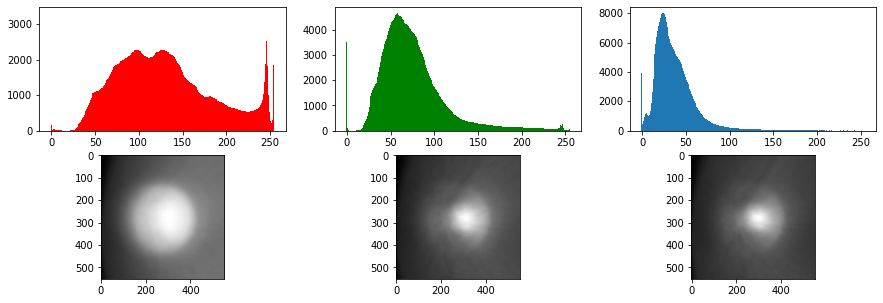

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(2,3,1), plt.bar(np.arange(0, 256)-0.5, hist_templates[0], width=1, color='r')
plt.subplot(2,3,2), plt.bar(np.arange(0, 256)-0.5, hist_templates[1], width=1, color = 'g')
plt.subplot(2,3,3), plt.bar(np.arange(0, 256)-0.5, hist_templates[2], width=1)
plt.subplot(2,3,4), plt.imshow(image_templates[0], cmap='gray')
plt.subplot(2,3,5), plt.imshow(image_templates[1], cmap='gray')
plt.subplot(2,3,6), plt.imshow(image_templates[2], cmap='gray')
plt.show()

In [119]:
localization_df = localization_df.to_dict()
methods = ['zhang']
for metode in methods:
  command = metode.split('_')
  tipe = command[0]
  rc, gc, bc, spc = (5,5,5,5)
  kanal='rg'
  bright=False
  if len(command)==2:
    kanal = command[1]
  elif len(command)==3:
    kanal = command[1]
    if int(command[2]) > 0:
      bright = True
  elif len(command)==4:
    kanal = command[1]
    if int(command[2]) > 0:
      bright = True
    rc = int(command[3][0])
    gc = int(command[3][1])
    bc = int(command[3][2])
    spc = int(command[3][3])
  
  percent_detection = []
  disc_centers = []
  mvoulana = []
  zheng = []
  for i in tqdm(range(len(df))):
    path = df["path"][i]
    path_OD = df["path_OD_GT"][i]
    path_OC = df["path_OC_GT"][i]

    src = cv2.imread(path, 1)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    OD_mask_gt = cv2.imread(path_OD, 0) 
    OC_mask_gt = cv2.imread(path_OC, 0)
    if tipe == 'image':
        disk_center = lokalisasiOD(src, image_templates, kanal=kanal,bright=bright, 
                                    rc=rc/5, bc=bc/5, gc=gc/5, spc=spc/5)
    elif tipe == 'histogram':
        disk_center = histogram_template_matching(src, hist_templates)

    elif tipe == 'zhang':
      disk_center = zhang_localization(src)
    
    percentage, mvo, zhe = checkROI(OD_mask_gt, disk_center)
    mvoulana.append(mvo)
    zheng.append(zhe)
    percent_detection.append(percentage)
    disc_centers.append(disk_center)

  mvoulana = np.array(mvoulana)
  zheng = np.array(zheng)
  percent_detection = np.array(percent_detection)
  disc_centers = np.array(disc_centers)
  print(metode, ' telah selesai!')
  localization_df[metode] = {'mvoulana':mvoulana, 
                             'zheng':zheng, 
                            'percent':percent_detection,
                            'disc center':disc_centers}


  0%|          | 0/450 [00:00<?, ?it/s]

zhang  telah selesai!


In [120]:
localization_df = pd.DataFrame(data=localization_df)
localization_df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/localization df.json')

In [121]:
mtd = 'zhang'
print(np.mean(localization_df[mtd]['percent']))
print(np.std(localization_df[mtd]['percent']))
print(np.sum(localization_df[mtd]['zheng'])*100/450)
print(np.sum(localization_df[mtd]['mvoulana'])*100/450)

96.30689290618385
14.154186105244976
66.66666666666667
78.88888888888889


In [118]:
mtd = 'histogram'
print(np.mean(localization_df[mtd]['percent']))
print(np.std(localization_df[mtd]['percent']))
print(np.sum(localization_df[mtd]['zheng'])*100/450)
print(np.sum(localization_df[mtd]['mvoulana'])*100/450)

98.73897201640906
10.66505731487349
96.22222222222223
98.44444444444444


In [ ]:
maps = []
for l in ix_temp:
    disk_center = df['disc_center'][l]
    src = cv2.imread(df['path'][l], 1)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    _, cormap = lokalisasiOD(src, image_templates, kanal='rg',test=True)
    _, red, green, bright = cormap
    maps.append([red, green, bright])

In [ ]:
def cost_function(w1, w2, w3, maps, center, OD):
  weighted_map = maps[0]*w1 + maps[1]*w2 + maps[2]*w3
  yo, xo = list(zip(*np.where(weighted_map==np.max(weighted_map))))[0]
  proporsi, _,_ = checkROI(OD, (xo, yo))
  return proporsi

def optimization(param, temp_idx, maps):
  path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/GridSearchROI/'
  result = np.zeros((len(param['w1']), len(param['w2']),len(param['w3'])))
  total = len(param['w1']) *len(param['w2']) * len(param['w3'])
  p = 0
  for i, w1 in enumerate(param['w1']):
    for j, w2 in enumerate(param['w2']):
      for k, w3 in enumerate(param['w3']):
        e = 0
        start = time.time()
        for l, ix in enumerate(temp_idx):
          disk_center = df['disc_center'][ix]
          OD = cv2.imread(df['path_OD_png'][ix], 0)
          proporsi = cost_function(w1, w2, w3, maps[l], disk_center, OD)
          e += proporsi

        p+=1
        end = time.time()
        clear_output(wait=True)
        print('Iteration time: {:.2f} s/it'.format(end-start))
        print('Progress: {}/{} ({:.2f}%)'.format(p, total, p*100/total))
        sisa_waktu = (total - p) * (end-start)
        print('Sisa waktu: {:.0f} m {:.2f} s'.format(sisa_waktu//60, sisa_waktu%60))
        me = e/(len(temp_idx))
        result[i, j, k] = me

  ix1, ix2, ix3 = list(zip(*np.where(result==np.max(result))))[0]
  bw1 = param['w1'][ix1]
  bw2 = param['w2'][ix2]
  bw3 = param['w3'][ix3]
  best_mp = np.max(result)
  print()
  print('best weight combination: w1 = {}, w2 = {}, w3 = {}'.format(bw1, bw2, bw3))     
  print('with mp = {:.2f}'.format(best_mp))
  return result, bw1, bw2, bw3

In [ ]:
param = {'w1': [0.2, 0.4, 0.6, 0.8, 1],
         'w2': [0.2, 0.4, 0.6, 0.8, 1],
         'w3': [0.2, 0.4, 0.6, 0.8, 1]}
result, bw1, bw2, bw3 = optimization(param, ix_temp, maps)

Iteration time: 9.73 s/it
Progress: 125/125 (100.00%)
Sisa waktu: 0 m 0.00 s

best weight combination: w1 = 1, w2 = 0.2, w3 = 0.2
with mp = 99.97


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


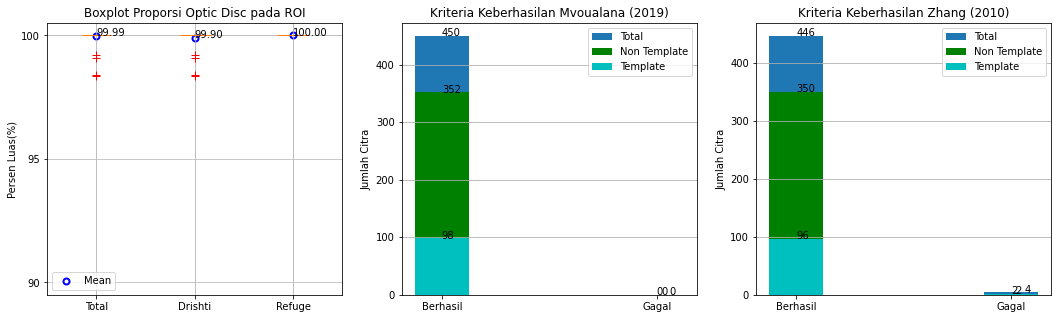

In [ ]:
plt.figure(figsize=(18, 5))
flierprops = dict(marker='+', markerfacecolor='g', markersize=8,
                  linestyle='none', markeredgecolor='r')
data_percent = [localization_df['image_gr_1_5104']['percent'], 
                localization_df['image_gr_1_5104']['percent'][:50],
                localization_df['image_gr_1_5104']['percent'][50:] ]

plt.subplot(1,3,1), plt.boxplot(data_percent, flierprops=flierprops)
plt.yticks(ticks=[90, 95, 100])

plt.ylabel('Persen Luas(%)')
plt.xticks([1, 2, 3], labels=['Total', 'Drishti', 'Refuge'])
means = [np.mean(data_percent[0]), np.mean(data_percent[1]), 
         np.mean(data_percent[2])]
s_means = ['{:.2f}'.format(x) for x in means]
plt.axhline(y=90, color = 'lightgray', linestyle = '-', lw=0.5)      
plt.axhline(y=95, color = 'lightgray', linestyle = '-', lw=0.5)               
plt.scatter(x=[1, 2, 3], y=means, c='w', edgecolor='b', linewidth=2, label='Mean')
plt.text(x=1, y=means[0], s=s_means[0], c='k', fontsize='medium')
plt.text(x=2, y=means[1], s=s_means[1], c='k', fontsize='medium')
plt.text(x=3, y=means[2], s=s_means[2], c='k', fontsize='medium')
plt.title('Boxplot Proporsi Optic Disc pada ROI')
plt.grid()
plt.legend()

mvoulana = localization_df['image_gr_1_5104']['mvoulana']
zheng = localization_df['image_gr_1_5104']['zheng']
# mvoualana
loc_total = (np.sum(mvoulana), 450 - np.sum(mvoulana))
loc_temp = (np.sum(mvoulana[ix_temp]), len(ix_temp) - np.sum(mvoulana[ix_temp]))
loc_non_temp = (np.sum(mvoulana[non_temp]), len(non_temp) - np.sum(mvoulana[non_temp]))
plt.subplot(1,3,2), 
plt.bar([1, 2], loc_total, width = 0.25, label='Total')
plt.bar([1, 2], loc_non_temp, width = 0.25, color='g', label='Non Template')
plt.bar([1, 2], loc_temp, width = 0.25, color='c', label='Template')

plt.xticks([1, 2], labels=['Berhasil', 'Gagal'])
plt.grid(axis ='y')
plt.text(x=1, y=np.sum(mvoulana), s='{}'.format(np.sum(mvoulana)), fontsize='medium' )
plt.text(x=2+0.06, y=450 - np.sum(mvoulana), s='{}'.format(int(450 - np.sum(mvoulana))), fontsize='medium' )
plt.text(x=1, y=np.sum(mvoulana[ix_temp]), s='{}'.format(np.sum(mvoulana[ix_temp])), fontsize='medium' )
plt.text(x=2, y= len(ix_temp)-np.sum(mvoulana[ix_temp]), s='{}'.format(int(len(ix_temp)-np.sum(mvoulana[ix_temp]))), fontsize='medium' )
plt.text(x=1, y=np.sum(mvoulana[non_temp]), s='{}'.format(np.sum(mvoulana[non_temp])), fontsize='medium' )
plt.text(x=2+0.02, y= len(non_temp)-np.sum(mvoulana[non_temp]), s='{}'.format(int(len(non_temp)-np.sum(mvoulana[non_temp]))), fontsize='medium' )
plt.ylabel('Jumlah Citra')
plt.title('Kriteria Keberhasilan Mvoualana (2019)')
plt.legend()

plt.subplot(1,3,3), 

loc_total = (np.sum(zheng), 450 - np.sum(zheng))
loc_temp = (np.sum(zheng[ix_temp]), len(ix_temp) - np.sum(zheng[ix_temp]))
loc_non_temp = (np.sum(zheng[non_temp]), len(non_temp) - np.sum(zheng[non_temp]))
plt.bar([1, 2], loc_total, width = 0.25, label='Total')
plt.bar([1, 2], loc_non_temp, width = 0.25, color='g', label='Non Template')
plt.bar([1, 2], loc_temp, width = 0.25, color='c', label='Template')

plt.xticks([1, 2], labels=['Berhasil', 'Gagal'])
plt.grid(axis ='y')

plt.text(x=1, y=np.sum(zheng), s='{}'.format(np.sum(zheng)), fontsize='medium' )
plt.text(x=2+0.06,y=450 - np.sum(zheng), s='{}'.format(int(450 - np.sum(zheng))), fontsize='medium' )
plt.text(x=1, y=np.sum(zheng[ix_temp]), s='{}'.format(np.sum(zheng[ix_temp])), fontsize='medium' )
plt.text(x=2, y= len(ix_temp)-np.sum(zheng[ix_temp]), s='{}'.format(int(len(ix_temp)-np.sum(zheng[ix_temp]))), fontsize='medium' )
plt.text(x=1, y=np.sum(zheng[non_temp]), s='{}'.format(np.sum(zheng[non_temp])), fontsize='medium' )
plt.text(x=2+0.02, y= len(non_temp)-np.sum(zheng[non_temp]), s='{}'.format(int(len(non_temp)-np.sum(zheng[non_temp]))), fontsize='medium' )
plt.ylabel('Jumlah Citra')
plt.title('Kriteria Keberhasilan Zhang (2010)')
plt.legend()

In [ ]:
localization_df.columns

Index(['histogram', 'image_g', 'image_gb', 'image_gr', 'image_rgb',
       'image_gr_1', 'image_gr_1_0514', 'image_gr_1_5101', 'image_gr_1_5104'],
      dtype='object')

<Figure size 432x360 with 0 Axes>

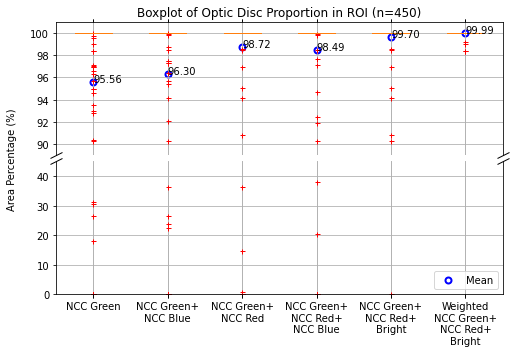

In [ ]:
plt.figure(figsize=(6, 5))
flierprops = dict(marker='+', markerfacecolor='g', markersize=5,
                  linestyle='none', markeredgecolor='r')
data_percent = [localization_df['image_g']['percent'],
                localization_df['image_gb']['percent'],
                localization_df['image_gr']['percent'], 
                localization_df['image_rgb']['percent'],
                localization_df['image_gr_1']['percent'], 
                localization_df['image_gr_1_5104']['percent']]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
fig.text(0.04, 0.5, 'Area Percentage (%)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.05)
means = [np.mean(x) for x in data_percent]
s_means = ['{:.2f}'.format(x) for x in means]
ax1.text(x=1, y=means[0], s=s_means[0], c='k', fontsize='medium')
ax1.text(x=2, y=means[1], s=s_means[1], c='k', fontsize='medium')
ax1.text(x=3, y=means[2], s=s_means[2], c='k', fontsize='medium')
ax1.text(x=4, y=means[3], s=s_means[3], c='k', fontsize='medium')
ax1.text(x=5, y=means[4], s=s_means[4], c='k', fontsize='medium')
ax1.text(x=6, y=means[5], s=s_means[5], c='k', fontsize='medium')

ax1.set_title('Boxplot of Optic Disc Proportion in ROI (n=450)')    
ax1.boxplot(data_percent, flierprops=flierprops)
ax2.boxplot(data_percent, flierprops=flierprops)
ax1.scatter(x=[1, 2, 3, 4, 5, 6], y=means, c='w', edgecolor='b', linewidth=2, label='Mean')
ax2.scatter(x=[1, 2, 3, 4, 5, 6], y=means, c='w', edgecolor='b', linewidth=2, label='Mean')
ax2.legend(loc='lower right')
ax1.set_ylim(89, 101)
ax2.set_ylim(0, 45)
ax2.set_xticklabels(['NCC Green', 'NCC Green+\nNCC Blue', 'NCC Green+\nNCC Red', 'NCC Green+\nNCC Red+\nNCC Blue',
                     'NCC Green+\nNCC Red+\nBright', 'Weighted\nNCC Green+\nNCC Red+\nBright'])

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.grid()
ax2.grid()

d = 0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.show()

In [ ]:
ix = list(np.where(localization_df['image_gr_1_5104']['percent'] < 100)[0])

In [ ]:
localization_df['image_gr_1_5104'].keys()

Index(['mvoulana', 'zheng', 'percent', 'disc center'], dtype='object')

In [ ]:
@interact(i=ix)

def roi(i = 0):
  disc_centers = localization_df['image_gr_1_5104']['disc center']
  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  disk_center = disc_centers[i]
  ROI_gt, koordinat = ekstrakROI(disk_center, 550, OD_mask_gt)
  percentage, _, _ = checkROI(OD_mask_gt, disk_center)
  # draw the bounding box on the image
  yo, yi,xo, xi = koordinat
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  img = src[:,:,1]
  img = clahe.apply(img)
  import matplotlib.patches as patches
  rectangle = patches.Rectangle((xo, yo), xi-xo, yi-yo, linewidth=2, 
                                edgecolor='r', facecolor='none')
  x, y = disk_center
    
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  plt.setp(ax, xticks=[], yticks=[])
  ax[0].imshow(ROI_gt, cmap='gray')
  ax[0].text(50, 50, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  ax[1].imshow(img, cmap ='gray')
  ax[1].text(90, 90, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  ax[1].add_patch(rectangle)
  ax[1].scatter(x, y, s=20, color='r', marker='x')

  plt.show()


  

interactive(children=(Dropdown(description='i', options=(10, 25, 35, 48), value=10), Output()), _dom_classes=(…

In [ ]:
@interact(i=(0, 450), rc=(1, 5), gc=(1, 5), spc=(1, 5))
def roi(i = 37,numSegments=50, sigma=10, rc=5, gc=1, spc=4):

  # input image dan ground truth

  path = df["path"][i]
  path_OD = df["path_OD_png"][i]
  path_OC = df["path_OC_png"][i]

  src = cv2.imread(path, 1)
  src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  OD_mask_gt = cv2.imread(path_OD, 0) 
  OC_mask_gt = cv2.imread(path_OC, 0)
  
  # ROI, koordinat, disk_center, cormap = percobaan_lokalisasi(src, test=True)
  disk_center, cormap = lokalisasiOD(src, image_templates, kanal='rg', 
                                             bright=True, test=True, 
                                             rc=1, gc=0.2, spc=0.8)
  """
  deteksi, percentage = checkROI(OD_mask_gt, disk_center)
  # draw the bounding box on the image
  yo, yi,xo, xi = koordinat
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  img = src[:,:,1]
  img = clahe.apply(img)
  import matplotlib.patches as patches
  rectangle = patches.Rectangle((xo, yo), xi-xo, yi-yo, linewidth=2, 
                                edgecolor='r', facecolor='none')
  y, x = np.where(cormap[0] == np.max(cormap[0]))
    
  blurred = cv2.GaussianBlur(img, (7, 7), 0)
  (T, mask) = cv2.threshold(blurred, 10 , 255, cv2.THRESH_BINARY)
  blur = cv2.GaussianBlur(src,(131, 131),0)
  segments = slic(blur, n_segments=numSegments, sigma=sigma, mask=mask)
  slic_img =mark_boundaries(blur, segments)
  ROI_gt, koordinat = ekstrakROI(disk_center, 550, OD_mask_gt)
  
  fig, ax = plt.subplots(2, 3, figsize=(18, 12))
  plt.setp(ax, xticks=[], yticks=[])
  ax[0, 0].imshow(ROI_gt, cmap='gray')
  ax[0, 0].text(50, 50, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  ax[0, 1].imshow(img, cmap ='gray')
  ax[0, 1].text(90, 90, '{} %'.format(round(percentage, 2)), fontsize='medium', color = 'y' )
  ax[0, 1].add_patch(rectangle)
  ax[0, 1].scatter(x, y, s=20, color='r', marker='x')
  ax[0, 2].imshow(cormap[0], cmap='gray')
  ax[0, 2].scatter(x, y, s=20, color='r', marker='x')
  ax[1, 0].imshow(cormap[1], cmap='gray')
  ax[1, 1].imshow(cormap[2], cmap='gray')
  ax[1, 2].imshow(cormap[3], cmap='gray')
  


  plt.show()
  """

interactive(children=(IntSlider(value=37, description='i', max=450), IntSlider(value=50, description='numSegme…